In [1]:
from __future__ import absolute_import, division, print_function

# Handling Census shapefiles

In this notebook I will experiment on the use of Census shapefiles. These files encode the boundaries of the urbanized areas as identified in the U.S. Census.

The data were downloaded from 
http://www2.census.gov/geo/tiger/TIGER2010/UA/2010/
via
https://www.census.gov/geo/reference/ua/urban-rural-2010.html


See https://glenbambrick.com/tag/pyshp/ for a very useful demo.

In [1]:
import os
import json
import pandas as pd
import glob
import numpy as np
import shapefile as sf
from pyproj import Proj, transform
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import copy

## Python packages - you may have to pip install sqlalchemy, sqlalchemy_utils, and psycopg2.
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

%matplotlib inline
mpl.rcParams['figure.figsize'] = 15, 6


In [3]:
def extract_coords(feature):
    """
    Extract coordinates from a shapefile feature.
    """    
    # if there is only one part
    if len(feature.parts) == 1:
        # create empty list to store all the coordinates
        poly_list = []
        # get each coord that makes up the polygon
        for coords in feature.points:
            x, y = coords[0], coords[1]
            poly_coord = [float(x), float(y)]
            # append the coords to the polygon list
            poly_list.append(poly_coord)
    # Handle geometries with multiple parts
    else:
        print('Multi-part file!')
        # append the total amount of points to the end of the parts list
        feature.parts.append(len(feature.points))
        # enpty list to store all the parts that make up the complete feature
        poly_list = []
        # keep track of the part being added
        parts_counter = 0
        # while the parts_counter is less than the amount of parts
        while parts_counter < len(feature.parts) - 1:
            # keep track of the amount of points added to the feature
            coord_count = feature.parts[parts_counter]
            # number of points in each part
            no_of_points = abs(feature.parts[parts_counter] - feature.parts[parts_counter + 1])
            # create list to hold individual parts - these get added to poly_list[]
            part_list = []
            # cut off point for each part
            end_point = coord_count + no_of_points
            # loop through each part
            while coord_count < end_point:
                for coords in feature.points[coord_count:end_point]:
                    x, y = coords[0], coords[1]
                    poly_coord = [float(x), float(y)]
                    # append the coords to the part list
                    part_list.append(poly_coord)
                    coord_count = coord_count + 1
            # append the part to the poly_list
            poly_list.append(part_list)
            parts_counter = parts_counter + 1
    return poly_list

# State of California

In [4]:
# State of California shape file
org_dir = os.path.join('..','data','urbanized_areas','cb_2015_us_state_500k')
shp_file = os.path.join(org_dir,'cb_2015_us_state_500k.shp')

In [5]:
# Read shapefile
shpf = sf.Reader(shp_file)
# Create a variable to access the records
records = shpf.records()

In [6]:
# Find column which contains the State abbreviation
name_list = []
lat_list = []
long_list = []
for idx,row in enumerate(records):
    if idx < 3:
        print(idx,row)


0 ['31', '01779792', '0400000US31', '31', 'NE', 'Nebraska', '00', 198972429772, 1356294775]
1 ['53', '01779804', '0400000US53', '53', 'WA', 'Washington', '00', 172121026344, 12540093192]
2 ['35', '00897535', '0400000US35', '35', 'NM', 'New Mexico', '00', 314161426332, 755674004]


In [7]:
# 4th column contains state (zero indexed)
sub = 'CA'
name_list = []
lat_list = []
long_list = []
for idx,row in enumerate(records):
    if sub in row[4]:
        print(idx,row)

# 'CA' column 4, row index 53 (both zero indexed)

53 ['06', '01779778', '0400000US06', '06', 'CA', 'California', '00', 403488955894, 20477992907]


In [8]:
# access the geometry of the features
geom = shpf.shapes()

In [9]:
# Extract the coordinates
feature = geom[53]
poly_list_ca = extract_coords(feature)


Multi-part file!


In [10]:
# Find longest sub-list to identify general state outline, ignoring islands and such
index_list = []
length_list = []
for idx,sublist in enumerate(poly_list_ca):
    index_list.append(idx)
    length_list.append(len(sublist))
    
max_len = max(length_list)
print('Max. length:', max_len)
max_index = [index for idx,index in enumerate(index_list) if length_list[idx] == max_len]
print('At index:', max_index)

Max. length: 4395
At index: [12]


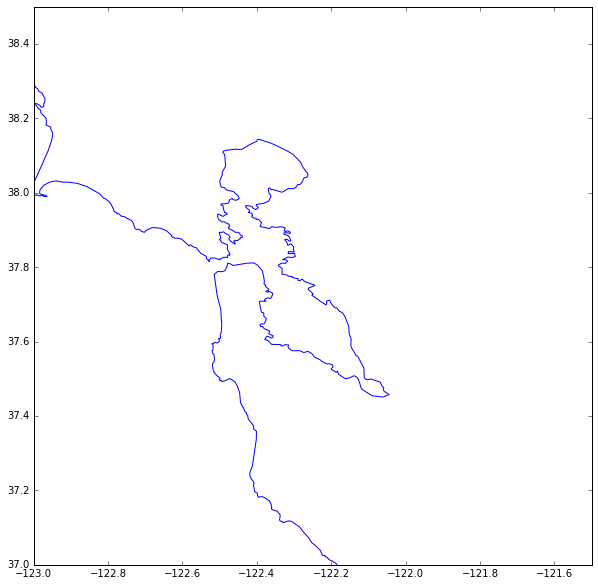

In [11]:
# plot and save coordinates for state of CA
plt.figure(figsize=(10,10))
for idx,tmp_list in enumerate(poly_list_ca):
    if idx == 12:
        x_coords = [x[0] for x in tmp_list]
        y_coords = [x[1] for x in tmp_list]
        x_coords_cal = x_coords
        y_coords_cal = y_coords

plt.plot(x_coords_cal,y_coords_cal)
plt.xlim(-123,-121.5)
plt.ylim(37,38.5)  
plt.show()

In [90]:
# save CA shape to disk
outfile = os.path.join('..','data','ca_shape.csv')
out = open(outfile,"w")
out.write('longitude,latitude\n')
for idx,coord in enumerate(x_coords_cal):
    out.write('{},{}\n'.format(coord,y_coords_cal[idx]))
out.close()
              
              



# Urbanized areas for California

In [12]:
# Now, read the urabnized area file for CA
org_dir = os.path.join('..','data','urbanized_areas','tl_2010_us_uac10')
shp_file = os.path.join(org_dir,'tl_2010_us_uac10.shp')
# Read shapefile
shpf = sf.Reader(shp_file)
# Create a variable to access the records
records = shpf.records()
# access the geometry of the features
geom = shpf.shapes()
# get the coordinates for sj
feature = geom[1176]
poly_list_sj = extract_coords(feature)

Multi-part file!


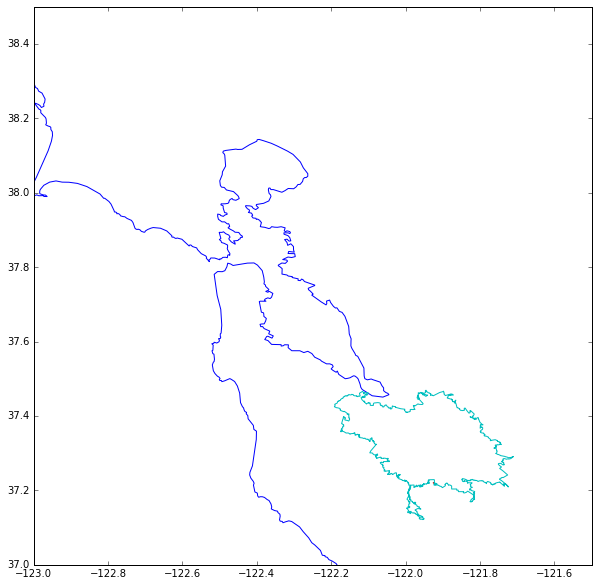

In [13]:
# plot CA and SJ
plt.figure(figsize=(10,10))
plt.plot(x_coords_cal,y_coords_cal)
plt.xlim(-123,-121.5)
plt.ylim(37,38.5)  
for tmp_list in poly_list_sj:
    x_coords = [x[0] for x in tmp_list]
    y_coords = [x[1] for x in tmp_list]
    plt.plot(x_coords,y_coords)
plt.show()

## Explore which locations are close to bay area

In [16]:
# extract long/lat of all cities. 3rd row contains city information
sub = 'CA'
name_list = []
lat_list = []
long_list = []
for idx,row in enumerate(records):
    if sub in row[2]:
        name_list.append(row[2])
        lat_list.append(row[10])
        long_list.append(row[11])


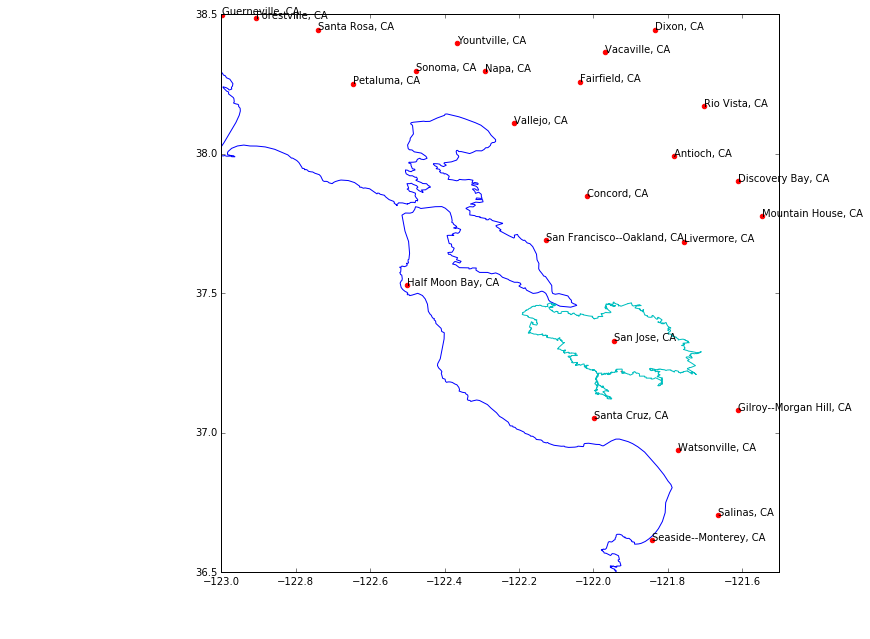

In [17]:
# plot CA, SJ, and cities
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(x_coords_cal,y_coords_cal)
plt.xlim(-123,-121.5)
plt.ylim(36.5,38.5)  
for tmp_list in poly_list_sj:
    x_coords = [x[0] for x in tmp_list]
    y_coords = [x[1] for x in tmp_list]
    plt.plot(x_coords,y_coords)
for idx,tmp_long in enumerate(long_list):
    plt.scatter(tmp_long,lat_list[idx],color='red')
    #print(name_list[idx])
    ax.annotate(name_list[idx], (tmp_long,lat_list[idx]))

plt.show()

In [18]:
# According to the graph above, we need to extract shapefiles for the following urban areas:
urban_area_list = {
    'Petaluma': 'pet',
    'Sonoma': 'son',
    'Yountville': 'yount',
    'Napa': 'napa',
    'Vallejo': 'val',
    'Concord': 'conc',
    'San Francisco': 'sf',
    'San Jose': 'sj',
    'Santa Cruz': 'sc',
    'Half Moon Bay': 'hmb',}

In [19]:
# find index for selected urban areas
urban_area_list_idx = {}
for urban_area in urban_area_list.keys():
    tmp_val = urban_area_list[urban_area]
    for idx,row in enumerate(records):
        if urban_area in row[2] and 'CA' in row[2]:
            urban_area_list_idx[tmp_val] = idx
print(urban_area_list_idx)

{'val': 1208, 'pet': 1049, 'son': 1191, 'sj': 1176, 'conc': 777, 'hmb': 990, 'napa': 1036, 'sc': 1180, 'sf': 1173, 'yount': 1223}


In [20]:
# get coordinates for each of the urban areas
urban_area_list_coords = {}
for urban_area in urban_area_list_idx.keys():
    tmp_idx = urban_area_list_idx[urban_area]
    feature = geom[tmp_idx]
    poly_list = extract_coords(feature)
    urban_area_list_coords[urban_area] = poly_list

Multi-part file!
Multi-part file!
Multi-part file!
Multi-part file!
Multi-part file!
Multi-part file!


In [21]:
out = np.array((x_coords_cal,y_coords_cal))
print(out)

[[-124.408601   -124.396642   -124.395598   ..., -124.407915   -124.409591
  -124.408601  ]
 [  40.443201     40.462119     40.46459036 ...,   40.435971     40.438076
    40.443201  ]]


In [22]:
print(np.transpose(out))

[[-124.408601     40.443201  ]
 [-124.396642     40.462119  ]
 [-124.395598     40.46459036]
 ..., 
 [-124.407915     40.435971  ]
 [-124.409591     40.438076  ]
 [-124.408601     40.443201  ]]


In [23]:
np.random.rand(10, 2)

array([[ 0.44916747,  0.6662269 ],
       [ 0.92666141,  0.97578522],
       [ 0.07948981,  0.22386733],
       [ 0.76777018,  0.0161489 ],
       [ 0.51461222,  0.53261677],
       [ 0.29369951,  0.73447599],
       [ 0.62848594,  0.55826662],
       [ 0.47481005,  0.49293619],
       [ 0.5039105 ,  0.06446806],
       [ 0.50398309,  0.36161844]])

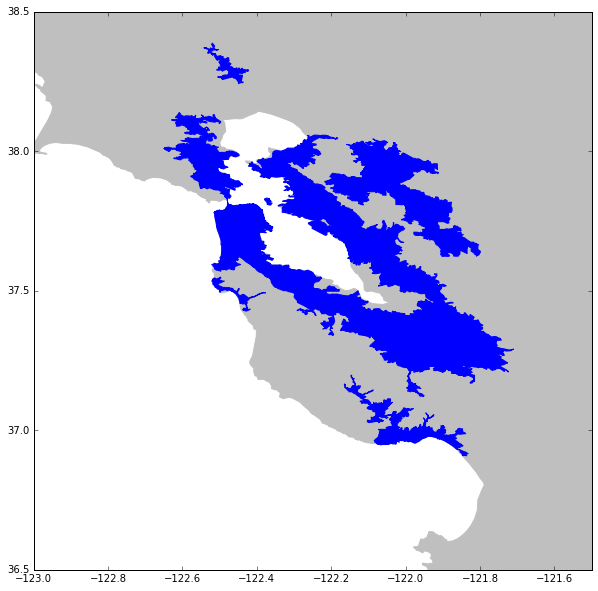

In [24]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Create patches list
patches = []
colors = []
# Create polygon for CA outline and attach to pacthes list
polygon = Polygon(np.transpose(np.array((x_coords_cal,y_coords_cal))), True)
patches.append(polygon)
colors.append('0.75')
# Create polygon for urbanized areas and attach to pactheslist
for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    try:
        for coord_list in tmp_list:
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            polygon = Polygon(np.transpose(np.array((x_coords,y_coords))), True)
            patches.append(polygon)
            colors.append('Blue')
    except:
        pass
#         x_coords = [x[0] for x in tmp_list]
#         y_coords = [x[1] for x in tmp_list]
#         polygon = Polygon(np.transpose(np.array((x_coords,y_coords))), True)
#         patches.append(polygon)
#         color.append('Red')


plt.xlim(-123,-121.5)
plt.ylim(36.5,38.5)  

collection = PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
plt.show()

# Extract data

In [3]:
# Add observed data
#In Python: Define a database name (we're using a dataset on births, so I call it 
# birth_db), and your username and password used above. 
dbname = 'flickr_db'
#username = 'username'
#pswd = 'password'
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
#engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
engine = create_engine('postgresql://@localhost/%s'%(dbname))
# Connect to an existing database
conn = psycopg2.connect("dbname=flickr_db")
# Open a cursor to perform database operations
cur = conn.cursor()


In [27]:
# Fetch data with unique id'd
# But for some reason, county was not commited
sql_string = """
Select Min(longitude) As longitude
    , id, latitude
From flickr_all
Group By id;
"""
sql_string = """
select * from flickr_all where
longitude in (Select max(longitude) FROM flickr_all group by id)
"""
sql_string = """
select id,longitude,latitude from flickr_all where
longitude in (Select max(longitude) FROM flickr_all group by id)
"""

sql_string = "SELECT longitude FROM flickr_all WHERE id = '653243567'"

cur.execute(sql_string)
rows = cur.fetchall()

In [226]:
import copy
final_rows = copy.copy(rows)


In [228]:
print(final_rows)

[(-122.302,), (-122.302,), (-122.302,)]


In [227]:
# ceck output
print(len(final_rows))

3


In [6]:
#Go directly into pands?

sql_query = """
SELECT id,longitude,latitude FROM flickr_all;
"""

flickr_fom_sql = pd.read_sql_query(sql_query,conn)

flickr_fom_sql.head()

,id,longitude,latitude
0,653243567,-122.302,37.7725
1,654102470,-122.302,37.7725
2,965675667,-122.064,37.8933
3,965675059,-122.064,37.8933
4,965674609,-122.204,37.8013


In [7]:
flickr_fom_sql.shape

(8310560, 3)

In [8]:
flickr_fom_sql_unique = flickr_fom_sql.drop_duplicates(subset='id',keep='first')

In [9]:
flickr_fom_sql_unique.shape

(4913276, 3)

In [229]:
print(flickr_fom_sql_unique.shape[0])
print(flickr_fom_sql_unique['longitude'][0])

4913276
-122.302


In [240]:
flickr_lng = flickr_fom_sql_unique['longitude'].tolist()
flickr_lat = flickr_fom_sql_unique['latitude'].tolist()

In [244]:
print(flickr_lng[0:10])

[-122.30200000000001, -122.30200000000001, -122.06399999999999, -122.06399999999999, -122.20399999999999, -122.20399999999999, -122.20399999999999, -122.20399999999999, -122.20399999999999, -122.20399999999999]


# Making further selections on data

Take the source data and select:

* all rows that could contain a keyword (title, tags,) and other, potentially interesting columns (id, longitude, latitude, dateupload, datetaken).


In [4]:
# Go directly into pandas?

sql_query = """
SELECT id,longitude,latitude,title,tags,dateupload,datetaken FROM flickr_all;
"""
flickr_fom_sql = pd.read_sql_query(sql_query,conn)


In [5]:
# Verify 
flickr_fom_sql.head()


,id,longitude,latitude,title,tags,dateupload,datetaken
0,653243567,-122.302,37.7725,CV18Ashtray,california museum ship ashtray aircraftcarrier...,1010011648,2007-06-28 16:33:50
1,654102470,-122.302,37.7725,waspcomp,california museum ship rack aircraftcarrier al...,1010011643,2007-06-28 16:33:48
2,965675667,-122.064,37.8933,IM000519,,1003836744,2001-10-18 14:56:11
3,965675059,-122.064,37.8933,IM000518,,1003836684,2001-10-18 14:55:54
4,965674609,-122.204,37.8013,IM000515,,1003836623,2001-10-17 17:37:57


In [6]:
# Remove duplicates
flickr_fom_sql_unique = flickr_fom_sql.drop_duplicates(subset='id',keep='first')

In [7]:
# Verify 
flickr_fom_sql_unique.head()


,id,longitude,latitude,title,tags,dateupload,datetaken
0,653243567,-122.302,37.7725,CV18Ashtray,california museum ship ashtray aircraftcarrier...,1010011648,2007-06-28 16:33:50
1,654102470,-122.302,37.7725,waspcomp,california museum ship rack aircraftcarrier al...,1010011643,2007-06-28 16:33:48
2,965675667,-122.064,37.8933,IM000519,,1003836744,2001-10-18 14:56:11
3,965675059,-122.064,37.8933,IM000518,,1003836684,2001-10-18 14:55:54
4,965674609,-122.204,37.8013,IM000515,,1003836623,2001-10-17 17:37:57


In [19]:
# Check how many rows have empty title AND tags
flickr_fom_sql_unique.isnull().sum().sum()

0

In [ ]:
# Save to pickle
flickr_fom_sql_unique.to_pickle(os.path.join('..','..','data','flickr_all_unique.df'))

# Test speed for keyword sleection: SQL vs. Pandas

In [2]:
# Add observed data
#In Python: Define a database name (we're using a dataset on births, so I call it 
# birth_db), and your username and password used above. 
dbname = 'flickr_db'
#username = 'username'
#pswd = 'password'
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
#engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
engine = create_engine('postgresql://@localhost/%s'%(dbname))
# Connect to an existing database
conn = psycopg2.connect("dbname=flickr_db")
# Open a cursor to perform database operations
cur = conn.cursor()


In [34]:
import time
start_time = time.time()
# set query string
sql_query = """
SELECT id,longitude,latitude,title,tags,dateupload,datetaken FROM flickr_all;
"""
# Run query and save in DF
flickr_fom_sql = pd.read_sql_query(sql_query,conn)
# Drop duplicates
flickr_fom_sql_unique = flickr_fom_sql.drop_duplicates(subset='id',keep='first')
# # Make title/tags lower case
# flickr_fom_sql_unique['title'] = flickr_fom_sql_unique['title'].str.lower()
# flickr_fom_sql_unique['tags'] = flickr_fom_sql_unique['tags'].str.lower()
# Select entries with 'dog' in Tag or Title
dog_title = flickr_fom_sql_unique[flickr_fom_sql_unique['title'].str.contains("dog",na=False)]
dog_tags = flickr_fom_sql_unique[flickr_fom_sql_unique['tags'].str.contains("dog", na=False)]
# Combine results
dog_all = dog_tags.append(dog_title)
# Drop duplicates
dog_all_clean = dog_all.drop_duplicates(subset='id', keep='first')

print("--- %s seconds ---" % (time.time() - start_time))

--- 130.60236311 seconds ---


In [35]:
dog_all_clean.shape

(34825, 7)

In [36]:
dog_all_clean.head()

,id,longitude,latitude,title,tags,dateupload,datetaken
291,81482,-122.291,37.8443,Dog sign,dog cameraphone,1089958863,2004-07-15 23:21:03
470,2501390,-122.222,37.8092,2 Brothers,dog goose springerspaniel isidore englishsprin...,1103914328,2004-12-24 09:07:38
484,2426142,-122.222,37.8092,Goose on porch,dog goose springerspaniel englishspringerspaniel,1103693350,2004-12-21 10:23:48
631,1702005,-122.274,37.8556,Peter and Buster,me fosterdog,1101420164,2004-11-25 14:02:44
640,1645391,-122.261,37.8718,Doggie,bw dog 35mm canon rangefinder scan peoplespark...,1101172010,2004-11-22 17:03:58


In [ ]:
# # Make titles/tags lower case for easier selection downstream
# insert_str = 'UPDATE flickr_all SET title=lower(title)'
# cur.execute(insert_str)
# insert_str = 'UPDATE flickr_all SET tags=lower(tags)'
# cur.execute(insert_str)


In [39]:
import time
start_time = time.time()
# set query string
sql_query = """
SELECT 
    id,longitude,latitude,title,tags,dateupload,datetaken 
FROM 
    flickr_all 
WHERE 
    title ~ 'dog' 
    OR
    tags ~ 'dog';
"""
# Run query and save in DF
try:
    flickr_fom_sql = pd.read_sql_query(sql_query,conn)
except:
    conn.rollback()
    # Drop duplicates
dog_all_clean = flickr_fom_sql.drop_duplicates(subset='id', keep='first')

print("--- %s seconds ---" % (time.time() - start_time))

--- 33.7297730446 seconds ---


In [40]:
dog_all_clean.shape

(34825, 7)

In [33]:
dog_all_clean.head()

,id,longitude,latitude,title,tags,dateupload,datetaken
0,258095,-122.276,37.8066,Bear or dog?,sign oakland text 14thstreet fav mlkway,1093472409,2004-08-25 15:20:09
1,81482,-122.291,37.8443,Dog sign,dog cameraphone,1089958863,2004-07-15 23:21:03
2,2501390,-122.222,37.8092,2 Brothers,dog goose springerspaniel isidore englishsprin...,1103914328,2004-12-24 09:07:38
3,2426142,-122.222,37.8092,Goose on porch,dog goose springerspaniel englishspringerspaniel,1103693350,2004-12-21 10:23:48
4,2242675,-122.285,37.8802,guard dog,lotusgreen,1103165729,2004-12-15 18:55:29


In [30]:
# rollback transaction that created errors
conn.rollback()

In [ ]:
# And commit the deletion
conn.commit()

## Testing if an image falls into the area of a shape

In [50]:
# Adapted from Tim Ivancic
# Adapted to accept a list of long/lat coordinates for the shape
# instead of the shape itself (which would require extracing coords)
# on each execution
def inshape(ptlon,ptlat,lon,minmax_lon,lat,minmax_lat):
    lon_max=minmax_lon[1]
    lon_min=minmax_lon[0]
    lat_max=minmax_lat[1]
    lat_min=minmax_lat[0]
    if (ptlat > lat_max or ptlat < lat_min or
        ptlon > lon_max or ptlon < lon_min):
        return False
    else:
        count = 0
        for i in range(len(lon)-1):
            line=[lon[i],lat[i],
                  lon[i+1],lat[i+1]]
            if ((line[1] < ptlat and line[3] > ptlat) or 
                (line[1] > ptlat and line[3] < ptlat)):
                frac = (line[1]-ptlat)/(line[1]-line[3])
                if line[0]+frac*(line[2]-line[0]) > ptlon:
                    count+=1
        line=[lon[-1],lat[0],
              lon[-1],lat[0]]                  
        if line[1] < ptlat and line[3] > ptlat:
            frac = (line[1]-ptlat)/(line[1]-line[3])
            if line[0]+frac*(line[2]-line[0]) > ptlon:
                count+=1
        if count%2 == 0:
            return True
        else:
            return False

#     return count%2               


In [9]:
# select every 100th point
flickr_lng = flickr_fom_sql_unique['longitude'].tolist()
flickr_lat = flickr_fom_sql_unique['latitude'].tolist()
# flickr_lng_sub = flickr_lng[0::1000]
# flickr_lat_sub = flickr_lat[0::1000]
flickr_lng_sub = flickr_lng[0:10000]
flickr_lat_sub = flickr_lat[0:10000]

In [55]:
import time
start_time = time.time()

inside_counter = 0
outside_counter = 0
# loop over shapes

# flickr_lat_sub = [37.416015]
# flickr_lng_sub=[-122.141183]

for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    #print(len(tmp_list[0]))
    if len(tmp_list[0]) > 2:
        for coord_list in tmp_list:
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            if len(x_coords) > 0 and len(y_coords) > 0:
                x_minmax = [min(x_coords),max(x_coords)]
                y_minmax = [min(y_coords),max(y_coords)]
                #print('\t',len(x_coords),len(y_coords))
                for index, row in enumerate(flickr_lng_sub):
                    tmp_lng = row
                    tmp_lat = flickr_lat_sub[index]
                    test = inshape(tmp_lng,tmp_lat,
                                   x_coords,x_minmax,
                                   y_coords,y_minmax)
                    if test == 0:
                        outside_counter += 1
                    else:
                        inside_counter += 1
            else:
                pass


    else:
        x_coords = [x[0] for x in tmp_list]
        y_coords = [x[1] for x in tmp_list]
        x_minmax = [min(x_coords),max(x_coords)]
        y_minmax = [min(y_coords),max(y_coords)]
        for index, row in enumerate(flickr_lng_sub):
            tmp_lng = row
            tmp_lat = flickr_lat_sub[index]

            test = inshape(tmp_lng,tmp_lat,
                           x_coords,x_minmax,
                           y_coords,y_minmax)
            if test:
                inside_counter += 1
            else:
                inside_counter += 1
print('Inside',',','Outside')
print(inside_counter,',',outside_counter)
    
print("--- %s seconds ---" % (time.time() - start_time))

2
2
1017
('\t', 1017, 1017)
('\t', 2759, 2759)
9
('\t', 9, 9)
('\t', 26, 26)
('\t', 10406, 10406)
8
('\t', 8, 8)
('\t', 19, 19)
('\t', 95, 95)
('\t', 7976, 7976)
2
2
26
('\t', 26, 26)
('\t', 25, 25)
('\t', 44, 44)
('\t', 90, 90)
('\t', 35, 35)
('\t', 70, 70)
('\t', 341, 341)
('\t', 12903, 12903)
17
('\t', 17, 17)
('\t', 11, 11)
('\t', 4, 4)
('\t', 35, 35)
('\t', 37, 37)
('\t', 30, 30)
('\t', 42, 42)
('\t', 109, 109)
('\t', 67, 67)
('\t', 218, 218)
('\t', 220, 220)
('\t', 301, 301)
('\t', 86, 86)
('\t', 759, 759)
('\t', 21688, 21688)
('\t', 14106, 14106)
24
('\t', 24, 24)
('\t', 2717, 2717)
('Inside', ',', 'Outside')
(50509, ',', 339491)
--- 170.633867979 seconds ---


### For 10,000 image records the above code took 234 seconds. 

### Calculating min/max lon/lat of shape outside function (i.e., only once for each shape) reduces time to: 171 seconds

### Using matplotlib contains_point below, it takes 84 seconds.

### Selection on extreme outliers from min/max criteria is very fast. Use this first to reduce number of points to check

In [71]:
# Select only images within SF&Oakland county (extreme) limits for testing
flickr_fom_sql_sf = flickr_fom_sql_unique[(flickr_fom_sql_unique['longitude'] > -123.17382) & 
                                       (flickr_fom_sql_unique['longitude'] < -122.28178) & 
                                       (flickr_fom_sql_unique['latitude'] > 37.63983) & 
                                       (flickr_fom_sql_unique['latitude'] < 37.92982)]




In [72]:
flickr_fom_sql_sf.head()

,id,longitude,latitude,title,tags,dateupload,datetaken
0,653243567,-122.302,37.7725,CV18Ashtray,california museum ship ashtray aircraftcarrier...,1010011648,2007-06-28 16:33:50
1,654102470,-122.302,37.7725,waspcomp,california museum ship rack aircraftcarrier al...,1010011643,2007-06-28 16:33:48
27,568984765,-122.373,37.8026,San Francisco downtown,sanfrancisco bridge beach golden bay gate san ...,1023659104,2002-06-09 14:45:04
44,1719122579,-122.304,37.8886,pinkness,,1030177245,2007-10-23 19:14:55
69,1985467107,-122.285,37.8802,marin in the fog,,1057554483,2007-11-12 08:34:38


## Check extreme outliers by min/max first

In [154]:
# Calculate min/max number 
urban_area_list_coords_flat_minmax = {}
for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    if len(tmp_list[0]) > 2:
        for idx,coord_list in enumerate(tmp_list):
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            if len(x_coords) > 0 and len(y_coords) > 0:
                x_min = min(x_coords)
                x_max = max(x_coords)
                y_min = min(y_coords)
                y_max = max(y_coords)
                if urban_area in urban_area_list_coords_flat_minmax.keys():
                    urban_area_list_coords_flat_minmax[urban_area+'_'+str(idx)] = [x_min,x_max,y_min,y_max]
                else:
                    urban_area_list_coords_flat_minmax[urban_area] = [x_min,x_max,y_min,y_max]
            
    else:
        x_coords = [x[0] for x in tmp_list]
        y_coords = [x[1] for x in tmp_list]
        x_min = min(x_coords)
        x_max = max(x_coords)
        y_min = min(y_coords)
        y_max = max(y_coords)
        urban_area_list_coords_flat_minmax[urban_area] = [x_min,x_max,y_min,y_max]
        

In [155]:
print(urban_area_list_coords_flat_minmax.keys())

['son_1', 'son', 'sf_2', 'sf_3', 'conc', 'sf_6', 'sf_7', 'sf_4', 'sf_5', 'sf_8', 'sf_9', 'val', 'pet', 'hmb_1', 'sf_10', 'sf_11', 'sf_12', 'sf_13', 'sf_14', 'sf_15', 'napa', 'conc_1', 'conc_2', 'conc_3', 'yount', 'sc_3', 'hmb', 'sc_7', 'sc_6', 'sc_5', 'sc_4', 'sj_2', 'sc_2', 'sc_1', 'sj_1', 'sj', 'sf_1', 'sc', 'sf']


In [161]:
# Run min/max check
flickr_lng = flickr_fom_sql_unique['longitude'].tolist()
flickr_lat = flickr_fom_sql_unique['latitude'].tolist()
flickr_lng_sub = flickr_lng[:]
flickr_lat_sub = flickr_lat[:]

start_time = time.time()

contains_list = [True] * len(flickr_lng_sub)

for index, row in enumerate(flickr_lng_sub):
    tmp_match_list = []
    tmp_lng = row
    tmp_lat = flickr_lat_sub[index]
    # loop through minmax of urban areas
    for urban_area in urban_area_list_coords_flat_minmax.keys():
        x_min = urban_area_list_coords_flat_minmax[urban_area][0]
        x_max = urban_area_list_coords_flat_minmax[urban_area][1]
        y_min = urban_area_list_coords_flat_minmax[urban_area][2]
        y_max = urban_area_list_coords_flat_minmax[urban_area][3]
        if (tmp_lat > y_max or tmp_lat < y_min or
            tmp_lng > x_max or tmp_lng < x_min):
            tmp_match_list.append(False)
        else:
            tmp_match_list.append(True)
    
    if sum(tmp_match_list) == 0:
        contains_list[index] = False
                
print('Unclear',',','Outside')
print(sum(contains_list),',',len(contains_list)-sum(contains_list))


print("--- %s seconds ---" % (time.time() - start_time))


Unclear , Outside
4522661 , 390615
--- 152.158327818 seconds ---


In [162]:
print(len(contains_list))

4913276


In [165]:
# Make a copy of the minmax results
contains_list_minmax = copy.copy(contains_list)

## For all points that cannot be excluded based on min/max considerations, use matplotlib patches to decide whether a point falls within a polygon

In [166]:
# Based on min/max check, 
flickr_fom_sql_unique.shape

(4913276, 7)

In [183]:
flickr_fom_sql_unique.head()

,id,longitude,latitude,title,tags,dateupload,datetaken
0,653243567,-122.302,37.7725,CV18Ashtray,california museum ship ashtray aircraftcarrier...,1010011648,2007-06-28 16:33:50
1,654102470,-122.302,37.7725,waspcomp,california museum ship rack aircraftcarrier al...,1010011643,2007-06-28 16:33:48
2,965675667,-122.064,37.8933,IM000519,,1003836744,2001-10-18 14:56:11
3,965675059,-122.064,37.8933,IM000518,,1003836684,2001-10-18 14:55:54
4,965674609,-122.204,37.8013,IM000515,,1003836623,2001-10-17 17:37:57


In [167]:
print(len(contains_list_minmax))

4913276


In [187]:
# Convert minmax_list to dataframe
minmax_frame = pd.DataFrame((np.transpose(np.array(contains_list_minmax))),columns=['minmax_inpoly'])
minmax_frame.head()


,minmax_inpoly
0,True
1,True
2,True
3,True
4,True


In [188]:
# Add both df's
flickr_fom_sql_unique_minmax = pd.concat([flickr_fom_sql_unique,minmax_frame], axis=1)
flickr_fom_sql_unique_minmax.head()

,id,longitude,latitude,title,tags,dateupload,datetaken,minmax_inpoly
0,653243567.0,-122.302,37.7725,CV18Ashtray,california museum ship ashtray aircraftcarrier...,1.010012e+09,2007-06-28 16:33:50,True
1,654102470.0,-122.302,37.7725,waspcomp,california museum ship rack aircraftcarrier al...,1.010012e+09,2007-06-28 16:33:48,True
2,965675667.0,-122.064,37.8933,IM000519,,1.003837e+09,2001-10-18 14:56:11,True
3,965675059.0,-122.064,37.8933,IM000518,,1.003837e+09,2001-10-18 14:55:54,True
4,965674609.0,-122.204,37.8013,IM000515,,1.003837e+09,2001-10-17 17:37:57,True


In [192]:
# select every 100th point
flickr_lng = flickr_fom_sql_unique_minmax['longitude'][flickr_fom_sql_unique_minmax['minmax_inpoly'] == True].tolist()
flickr_lat = flickr_fom_sql_unique_minmax['latitude'][flickr_fom_sql_unique_minmax['minmax_inpoly'] == True].tolist()
flickr_lng_sub = flickr_lng[:]
flickr_lat_sub = flickr_lat[:]

In [198]:
flickr_fom_sql_unique_minmax.head()

,id,longitude,latitude,title,tags,dateupload,datetaken,minmax_inpoly
0,653243567.0,-122.302,37.7725,CV18Ashtray,california museum ship ashtray aircraftcarrier...,1.010012e+09,2007-06-28 16:33:50,True
1,654102470.0,-122.302,37.7725,waspcomp,california museum ship rack aircraftcarrier al...,1.010012e+09,2007-06-28 16:33:48,True
2,965675667.0,-122.064,37.8933,IM000519,,1.003837e+09,2001-10-18 14:56:11,True
3,965675059.0,-122.064,37.8933,IM000518,,1.003837e+09,2001-10-18 14:55:54,True
4,965674609.0,-122.204,37.8013,IM000515,,1.003837e+09,2001-10-17 17:37:57,True


# How about some dogs

In [201]:
# convert title and tag column to all lower case
flickr_fom_sql_unique['title'] = flickr_fom_sql_unique['title'].str.lower()
flickr_fom_sql_unique['tags'] = flickr_fom_sql_unique['tags'].str.lower()

In [202]:
flickr_fom_sql_unique_minmax.head()

,id,longitude,latitude,title,tags,dateupload,datetaken,minmax_inpoly
0,653243567.0,-122.302,37.7725,cv18ashtray,california museum ship ashtray aircraftcarrier...,1.010012e+09,2007-06-28 16:33:50,True
1,654102470.0,-122.302,37.7725,waspcomp,california museum ship rack aircraftcarrier al...,1.010012e+09,2007-06-28 16:33:48,True
2,965675667.0,-122.064,37.8933,im000519,,1.003837e+09,2001-10-18 14:56:11,True
3,965675059.0,-122.064,37.8933,im000518,,1.003837e+09,2001-10-18 14:55:54,True
4,965674609.0,-122.204,37.8013,im000515,,1.003837e+09,2001-10-17 17:37:57,True


In [66]:
# Pre-select on mentions of 'dog'
dog_title = flickr_fom_sql_unique[(flickr_fom_sql_unique['title'].str.contains("dog",na=False)) & 
                                  (flickr_fom_sql_unique['title'].str.contains("dog",na=False)  == False )]
dog_tags = flickr_fom_sql_unique[flickr_fom_sql_unique['tags'].str.contains("dog", na=False)]

In [65]:
dog_title = flickr_fom_sql_unique[(flickr_fom_sql_unique['id'] == 653243567.0) & 
                                  (flickr_fom_sql_unique['title'].str.contains("dog",na=False)  == False)]


In [248]:
dog_title.shape

(12039, 8)

In [249]:
dog_title.head()

,id,longitude,latitude,title,tags,dateupload,datetaken,minmax_inpoly
271,258095.0,-122.276,37.8066,bear or dog?,sign oakland text 14thstreet fav mlkway,1.093472e+09,2004-08-25 15:20:09,True
291,81482.0,-122.291,37.8443,dog sign,dog cameraphone,1.089959e+09,2004-07-15 23:21:03,True
371,2861773.0,-122.322,37.5614,man and dog,bw pinhole zoneplate blur zeroimage people,1.104732e+09,2005-01-02 21:57:58,True
555,2242675.0,-122.285,37.8802,guard dog,lotusgreen,1.103166e+09,2004-12-15 18:55:29,True
640,1645391.0,-122.261,37.8718,doggie,bw dog 35mm canon rangefinder scan peoplespark...,1.101172e+09,2004-11-22 17:03:58,True


In [208]:
dog_tags.shape

(29803, 8)

In [250]:
dog_tags.head()

,id,longitude,latitude,title,tags,dateupload,datetaken,minmax_inpoly
291,81482.0,-122.291,37.8443,dog sign,dog cameraphone,1.089959e+09,2004-07-15 23:21:03,True
470,2501390.0,-122.222,37.8092,2 brothers,dog goose springerspaniel isidore englishsprin...,1.103914e+09,2004-12-24 09:07:38,True
484,2426142.0,-122.222,37.8092,goose on porch,dog goose springerspaniel englishspringerspaniel,1.103693e+09,2004-12-21 10:23:48,True
631,1702005.0,-122.274,37.8556,peter and buster,me fosterdog,1.101420e+09,2004-11-25 14:02:44,True
640,1645391.0,-122.261,37.8718,doggie,bw dog 35mm canon rangefinder scan peoplespark...,1.101172e+09,2004-11-22 17:03:58,True


In [252]:
# Put them both together
dog_all = dog_tags.append(dog_title)
dog_all.shape

(41842, 8)

In [254]:
dog_all_clean = dog_all.drop_duplicates(subset='id', keep='first')
dog_all_clean.shape

(37440, 8)

In [255]:
# Plot doggy pictures on map
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import time

start_time = time.time()

flickr_lng = dog_all_clean['longitude'].tolist()
flickr_lat = dog_all_clean['latitude'].tolist()


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Create patches list
patches = []
colors = []
# Create polygon for CA outline and attach to pacthes list
polygon = Polygon(np.transpose(np.array((x_coords_cal,y_coords_cal))), True)
patches.append(polygon)
colors.append('0.85')
# Create polygon for urbanized areas and attach to pactheslist
for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    try:
        for coord_list in tmp_list:
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            polygon = Polygon(np.transpose(np.array((x_coords,y_coords))), True)
            patches.append(polygon)
            colors.append('0.75')
    except:
        pass


plt.xlim(-123,-121.5)
plt.ylim(36.5,38.5)  
# Draw shpes
collection = PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
# Add datapoints
for index, row in enumerate(flickr_lng):
    tmp_lng = row
    tmp_lat = flickr_lat[index]
    plt.plot(tmp_lng,tmp_lat,'+r',markersize=2)
plt.savefig('test_dog_all.png',bbox_inches='tight')
#plt.show()
plt.close()
print("--- %s seconds ---" % (time.time() - start_time))

--- 92.0753600597 seconds ---


### That does not look too promising. Very little dog pictures in non-urban areas close to the bay.

## Try traffic incidents instead

In [256]:
# Pre-select on mentions of traffic incident realted language
searchfor = ['accident', 'crash']
traffic_title = flickr_fom_sql_unique_minmax[flickr_fom_sql_unique_minmax['title']
                                             .str.contains("|".join(searchfor),na=False)]
traffic_tags = flickr_fom_sql_unique_minmax[flickr_fom_sql_unique_minmax['tags']
                                             .str.contains("|".join(searchfor),na=False)]


In [259]:
traffic_title.shape

(1743, 8)

In [260]:
traffic_tags.shape

(3075, 8)

In [261]:
# Put them both together
traffic_all = traffic_tags.append(traffic_title)
traffic_all.shape

(4818, 8)

In [262]:
traffic_all_clean = traffic_all.drop_duplicates(subset='id', keep='first')
traffic_all_clean.shape

(4280, 8)

In [264]:
# Plot traffic pictures on map
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import time

start_time = time.time()

flickr_lng = traffic_all_clean['longitude'].tolist()
flickr_lat = traffic_all_clean['latitude'].tolist()


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Create patches list
patches = []
colors = []
# Create polygon for CA outline and attach to pacthes list
polygon = Polygon(np.transpose(np.array((x_coords_cal,y_coords_cal))), True)
patches.append(polygon)
colors.append('0.85')
# Create polygon for urbanized areas and attach to pactheslist
for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    try:
        for coord_list in tmp_list:
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            polygon = Polygon(np.transpose(np.array((x_coords,y_coords))), True)
            patches.append(polygon)
            colors.append('0.75')
    except:
        pass


plt.xlim(-123,-121.5)
plt.ylim(36.5,38.5)  
# Draw shpes
collection = PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
# Add datapoints
for index, row in enumerate(flickr_lng):
    tmp_lng = row
    tmp_lat = flickr_lat[index]
    plt.plot(tmp_lng,tmp_lat,'+r',markersize=2)
plt.savefig('test_traffic_all.png',bbox_inches='tight')
#plt.show()
plt.close()
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.15709805489 seconds ---


## Try traffic itself

In [37]:
# Pre-select on mentions of traffic incident realted language
traffic_title = flickr_fom_sql_unique[flickr_fom_sql_unique['title']
                                      .str.contains("traffic",na=False)]
traffic_tags = flickr_fom_sql_unique[flickr_fom_sql_unique['tags']
                                     .str.contains("traffic",na=False)]


In [38]:
traffic_title.shape

(857, 7)

In [39]:
traffic_tags.shape

(6733, 7)

In [40]:
# Put them both together
traffic_all = traffic_tags.append(traffic_title)
traffic_all.shape

(7590, 7)

In [41]:
traffic_all_clean = traffic_all.drop_duplicates(subset='id', keep='first')
traffic_all_clean.shape

(7445, 7)

In [42]:
# Plot traffic pictures on map
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import time

start_time = time.time()

flickr_lng = traffic_all_clean['longitude'].tolist()
flickr_lat = traffic_all_clean['latitude'].tolist()


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Create patches list
patches = []
colors = []
# Create polygon for CA outline and attach to pacthes list
polygon = Polygon(np.transpose(np.array((x_coords_cal,y_coords_cal))), True)
patches.append(polygon)
colors.append('0.85')
# Create polygon for urbanized areas and attach to pactheslist
for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    try:
        for coord_list in tmp_list:
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            polygon = Polygon(np.transpose(np.array((x_coords,y_coords))), True)
            patches.append(polygon)
            colors.append('0.75')
    except:
        pass


plt.xlim(-123,-121.5)
plt.ylim(36.5,38.5)  
# Draw shpes
collection = PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
# Add datapoints
for index, row in enumerate(flickr_lng):
    tmp_lng = row
    tmp_lat = flickr_lat[index]
    plt.plot(tmp_lng,tmp_lat,'+r',markersize=2)
plt.savefig('test_traffic_generic.png',bbox_inches='tight')
#plt.show()
plt.close()
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.8376581669 seconds ---


# Try motorcycles

In [68]:
# Pre-select on mentions of traffic incident realted language
query = flickr_fom_sql_unique['title'].str.contains("motorcycle",na=False)

motorcycle_title = flickr_fom_sql_unique[query]



# motorcycle_title = flickr_fom_sql_unique[flickr_fom_sql_unique['title']
#                                       .str.contains("motorcycle",na=False)]
# motorcycle_tags = flickr_fom_sql_unique[flickr_fom_sql_unique['tags']
#                                      .str.contains("motorcycle",na=False)]


In [69]:
motorcycle_title.shape

(275, 7)

In [47]:
motorcycle_tags.shape

(6355, 7)

In [48]:
# Put them both together
motorcycle_all = motorcycle_tags.append(motorcycle_title)
motorcycle_all.shape

(6630, 7)

In [49]:
motorcycle_all_clean = motorcycle_all.drop_duplicates(subset='id', keep='first')
motorcycle_all_clean.shape

(6586, 7)

In [50]:
# Plot traffic pictures on map
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import time

start_time = time.time()

flickr_lng = motorcycle_all_clean['longitude'].tolist()
flickr_lat = motorcycle_all_clean['latitude'].tolist()


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Create patches list
patches = []
colors = []
# Create polygon for CA outline and attach to pacthes list
polygon = Polygon(np.transpose(np.array((x_coords_cal,y_coords_cal))), True)
patches.append(polygon)
colors.append('0.85')
# Create polygon for urbanized areas and attach to pactheslist
for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    try:
        for coord_list in tmp_list:
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            polygon = Polygon(np.transpose(np.array((x_coords,y_coords))), True)
            patches.append(polygon)
            colors.append('0.75')
    except:
        pass


plt.xlim(-123,-121.5)
plt.ylim(36.5,38.5)  
# Draw shpes
collection = PatchCollection(patches)
ax.add_collection(collection)
collection.set_color(colors)
# Add datapoints
for index, row in enumerate(flickr_lng):
    tmp_lng = row
    tmp_lat = flickr_lat[index]
    plt.plot(tmp_lng,tmp_lat,'+r',markersize=2)
plt.savefig('test_motorcycle.png',bbox_inches='tight')
#plt.show()
plt.close()
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.7362110615 seconds ---


In [85]:
def create_tag_map(tag_list,exclusions='',plot=False):
    """
    Create a map of the bay area showing the geographic distribution
    of Flickr images matching a serach string.
    If 'tag_list' is a list, they will be combined with OR.
    """
    if len(exclusions) > 0:
        exclusion_flag = True
        if type(exclusions) == list:
            exclusion_title = flickr_fom_sql_unique['title'].str.contains("|".join(exclusions),na=False)  == False
            exclusion_tag = flickr_fom_sql_unique['tags'].str.contains("|".join(exclusions),na=False)  == False
        else:
            exclusion_title = flickr_fom_sql_unique['title'].str.contains(exclusions,na=False)  == False
            exclusion_tag = flickr_fom_sql_unique['tags'].str.contains(exclusions,na=False)  == False
    else:
        exclusion_flag = False
            
    if type(tag_list) == list:
        query_title = flickr_fom_sql_unique['title'].str.contains("|".join(searchfor),na=False)
        query_tag = flickr_fom_sql_unique['tags'].str.contains("|".join(searchfor),na=False)
    else:
        query_title = flickr_fom_sql_unique['title'].str.contains(tag_list,na=False)
        query_tag = flickr_fom_sql_unique['tags'].str.contains(tag_list,na=False)
    if exclusion_flag:
        title_matches = flickr_fom_sql_unique[(query_title) & (exclusion_title)]
        tag_matches = flickr_fom_sql_unique[(query_tag) & (exclusion_tag)]
    else:
        title_matches = flickr_fom_sql_unique[(query_title)]
        tag_matches = flickr_fom_sql_unique[(query_tag)]
    # Put them both together
    all_matches = tag_matches.append(title_matches)
    # Remove duplicates
    all_matches_clean = all_matches.drop_duplicates(subset='id', keep='first')
    # Plot if requested
    if plot:
        # Plot traffic pictures on map
        from matplotlib.patches import Polygon
        from matplotlib.collections import PatchCollection
        flickr_lng = all_matches_clean['longitude'].tolist()
        flickr_lat = all_matches_clean['latitude'].tolist()
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        # Create patches list
        patches = []
        colors = []
        # Create polygon for CA outline and attach to pacthes list
        polygon = Polygon(np.transpose(np.array((x_coords_cal,y_coords_cal))), True)
        patches.append(polygon)
        colors.append('0.85')
        # Create polygon for urbanized areas and attach to pactheslist
        for urban_area in urban_area_list_coords.keys():
            tmp_list = urban_area_list_coords[urban_area]
            try:
                for coord_list in tmp_list:
                    x_coords = [x[0] for x in coord_list]
                    y_coords = [x[1] for x in coord_list]
                    polygon = Polygon(np.transpose(np.array((x_coords,y_coords))), True)
                    patches.append(polygon)
                    colors.append('0.75')
            except:
                pass
        plt.xlim(-123,-121.5)
        plt.ylim(36.5,38.5)  
        # Draw shpes
        collection = PatchCollection(patches)
        ax.add_collection(collection)
        collection.set_color(colors)
        # Add datapoints
        for index, row in enumerate(flickr_lng):
            tmp_lng = row
            tmp_lat = flickr_lat[index]
            plt.plot(tmp_lng,tmp_lat,'+r',markersize=2)
        if type(tag_list)  == list:
            outfile = 'test_'+'_'.join(tag_list)+'.png'
        else:
            outfile = 'test_'+tag_list+'.png'
        plt.savefig(outfile,bbox_inches='tight')
        #plt.show()
        plt.close()
    return all_matches_clean
    
    

In [86]:
start_time = time.time()

out = create_tag_map('dog',plot=False)

print("--- %s seconds ---" % (time.time() - start_time))

--- 7.77597594261 seconds ---


In [88]:
out.to_pickle(os.path.join('..','data','dog.df'))

In [ ]:
# Get random 100k llines from data frame (4.9m)

In [193]:
# Calculate paths number 
urban_area_list_coords_flat_path = {}
for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    if len(tmp_list[0]) > 2:
        for idx,coord_list in enumerate(tmp_list):
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            if len(x_coords) > 0 and len(y_coords) > 0:
                bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)
                if urban_area in urban_area_list_coords_flat_path.keys():
                    urban_area_list_coords_flat_path[urban_area+'_'+str(idx)] = bbPath
                else:
                    urban_area_list_coords_flat_path[urban_area] = bbPath
            
    else:
        x_coords = [x[0] for x in tmp_list]
        y_coords = [x[1] for x in tmp_list]
        x_min = min(x_coords)
        x_max = max(x_coords)
        y_min = min(y_coords)
        y_max = max(y_coords)
        urban_area_list_coords_flat_path[urban_area] = bbPath
        

In [194]:
print(urban_area_list_coords_flat_path)

{'son_1': Path(array([[-122.519348,   38.351343],
       [-122.518553,   38.351527],
       [-122.518356,   38.351546],
       ..., 
       [-122.518996,   38.350922],
       [-122.519263,   38.351238],
       [-122.519348,   38.351343]]), array([ 1,  2,  2, ...,  2,  2, 79], dtype=uint8)), 'son': Path(array([[-122.519348,   38.351343],
       [-122.519544,   38.351297],
       [-122.519579,   38.35128 ],
       ..., 
       [-122.519871,   38.35196 ],
       [-122.519753,   38.351843],
       [-122.519348,   38.351343]]), array([ 1,  2,  2, ...,  2,  2, 79], dtype=uint8)), 'sf_2': Path(array([[-122.37997 ,   37.760224],
       [-122.38017 ,   37.762124],
       [-122.37987 ,   37.762224],
       [-122.37997 ,   37.760224]]), array([ 1,  2,  2, 79], dtype=uint8)), 'sf_3': Path(array([[-122.53431 ,   38.06468 ],
       [-122.534062,   38.064887],
       [-122.534038,   38.064917],
       [-122.534022,   38.064938],
       [-122.533991,   38.065005],
       [-122.533977,   38.065077],
  

In [197]:
flickr_lng_sub = flickr_lng[:10000]
flickr_lat_sub = flickr_lat[:10000]

# Run path check
start_time = time.time()

contains_list = [False] * len(flickr_lng_sub)

for index, row in enumerate(flickr_lng_sub):
    tmp_match_list = []
    tmp_lng = row
    tmp_lat = flickr_lat_sub[index]
    # loop through minmax of urban areas
    for urban_area in urban_area_list_coords_flat_path.keys():
        bbPath = urban_area_list_coords_flat_path[urban_area]
        test = bbPath.contains_point((tmp_lng, tmp_lat))
        if test:
            tmp_match_list.append(True)
        else:
            tmp_match_list.append(False)

    if sum(tmp_match_list) > 0:
        contains_list[index] = True
                
print('Inside',',','Outside')
print(sum(contains_list),',',len(contains_list)-sum(contains_list))


print("--- %s seconds ---" % (time.time() - start_time))


Inside , Outside
9194 , 806
--- 103.393604994 seconds ---


In [ ]:
# Try an aletrnative using matplotlib paths
# http://stackoverflow.com/questions/16625507/python-checking-if-point-is-inside-a-polygon

import matplotlib.path as mplPath
import numpy as np
import time

start_time = time.time()

contains_list = [False] * len(flickr_lng_sub)

# flickr_lat_sub = [37.416015]
# flickr_lng_sub = [-122.141183]
# flickr_lat_sub = [37.740346]
# flickr_lng_sub = [-122.441928]

for urban_area in urban_area_list_coords.keys():
    tmp_list = urban_area_list_coords[urban_area]
    if len(tmp_list[0]) > 2:
        for coord_list in tmp_list:
            x_coords = [x[0] for x in coord_list]
            y_coords = [x[1] for x in coord_list]
            if len(x_coords) > 0 and len(y_coords) > 0:
                bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)        
                for index, row in enumerate(flickr_lng_sub):
                    tmp_lng = row
                    tmp_lat = flickr_lat_sub[index]
                    test = bbPath.contains_point((tmp_lng, tmp_lat))
                    contains_list[index] = test
#                     if test:
#                         print(urban_area)
            else:
                pass
    else:
        x_coords = [x[0] for x in tmp_list]
        y_coords = [x[1] for x in tmp_list]
        bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)        
        for index, row in enumerate(flickr_lng_sub):
            tmp_lng = row
            tmp_lat = flickr_lat_sub[index]
            test = bbPath.contains_point((tmp_lng, tmp_lat))
            contains_list[index] = test
print('Inside',',','Outside')
print(sum(contains_list),',',len(contains_list)-sum(contains_list))


print("--- %s seconds ---" % (time.time() - start_time))